In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [21]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [22]:
# ----Part 1---- 
# Question a)
# Image path
data_dir = "./"

# Basic Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",# assgin the label based on the folder names "damge, no damage"
    label_mode = "int",
    validation_split = 0.2, 
    subset= "training",
    seed = SEED,
    image_size = IMG_SIZE, 
    batch_size = BATCH_SIZE
)
    
# validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Save the Class 
class_names = train_ds.class_names
print("Class names:", class_names)


Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.
Class names: ['damage', 'no_damage']


In [23]:
# Question B)
# Checking the Image and Label Size
for images, labels in train_ds.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)
    break

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


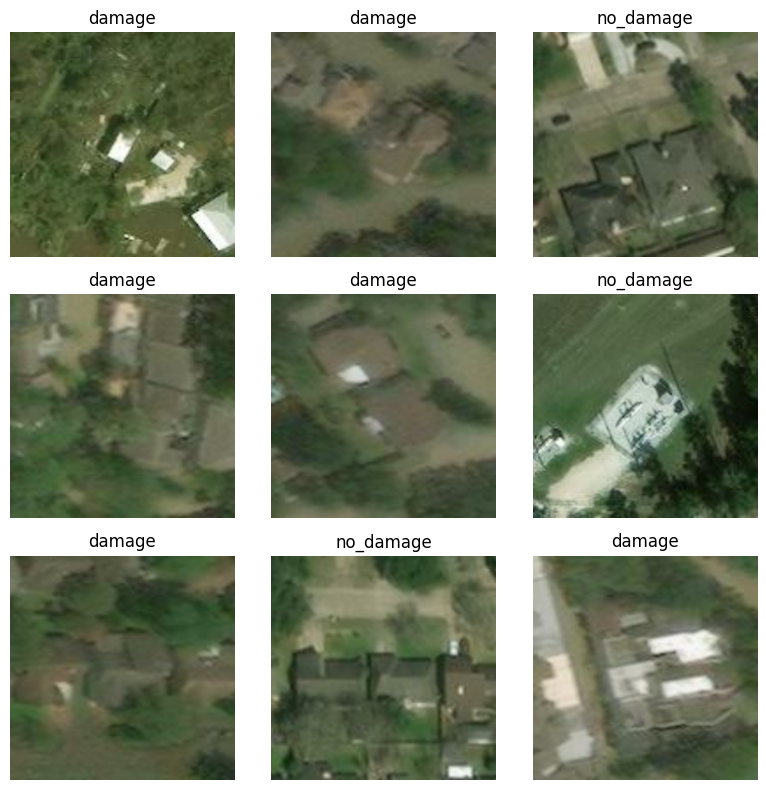

In [24]:
plt.figure(figsize=(8,8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.tight_layout()
plt.show()


In [25]:
# count how many image per class
import glob
counts = {cls: len(glob.glob(os.path.join(data_dir, cls, "*"))) for cls in class_names}
print("Image counts per class:", counts)


Image counts per class: {'damage': 14170, 'no_damage': 7152}


In [26]:
val_batches = tf.data.experimental.cardinality(val_ds) # counts how many batchers are inside a val_ds
test_ds = val_ds.take(val_batches // 2) # give half of the bathes to the test 
val_ds  = val_ds.skip(val_batches // 2) # half of to the validation

In [27]:
# Normalization
normalization_layer = tf.keras.layers.Rescaling(1./255)
def normalize(images, labels):
    return normalization_layer(images), labels

train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

In [28]:
for images, labels in train_ds.take(1):
    print("Image shape:", images.shape)
    print("Pixel range (after normalization):", tf.reduce_min(images).numpy(), "-", tf.reduce_max(images).numpy())


Image shape: (32, 224, 224, 3)
Pixel range (after normalization): 0.0 - 1.0


In [29]:
import numpy as np

count0 = 0
count1 = 0
for _, y in train_ds:
    y = y.numpy()
    count0 += (y == 0).sum()
    count1 += (y == 1).sum()

print("no_damage:", count0, "damage:", count1)

no_damage: 11353 damage: 5705


# Part 2: Model design, training and evaluation

In [30]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

## Instantiate Models

In [31]:
def create_dense_ann(input_shape=(128, 128, 3), num_classes=1):
    """
    Dense (Fully Connected) Artificial Neural Network
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Flatten the input images
        layers.Flatten(input_shape=input_shape),
        
        # Dense layers with dropout for regularization
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        
        # Output layer - sigmoid for binary classification
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(thresholds=0.3), tf.keras.metrics.Recall(thresholds=0.3)]
    )
    
    return model

In [32]:
def create_lenet5(input_shape=(128, 128, 3), num_classes=1):
    """
    LeNet-5 CNN Architecture (adapted for colored images)
    Original LeNet-5 was designed for 32x32 grayscale images,
    this is adapted for larger RGB images.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(6, kernel_size=(5, 5), activation='tanh', 
                      input_shape=input_shape, padding='same'),
        layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        
        # Second Convolutional Block
        layers.Conv2D(16, kernel_size=(5, 5), activation='tanh'),
        layers.AveragePooling2D(pool_size=(2, 2), strides=2),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(120, activation='tanh'),
        layers.Dense(84, activation='tanh'),
        
        # Output layer - sigmoid for binary classification
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(thresholds=0.3), tf.keras.metrics.Recall(thresholds=0.3)]
    )
    
    return model

In [33]:
def create_alternate_lenet5(input_shape=(128, 128, 3), num_classes=1):
    """
    Alternate-LeNet-5 CNN Architecture
    Based on Table 1, Page 12 of https://arxiv.org/pdf/1807.01688.pdf
    
    This architecture uses:
    - 3 Convolutional layers with ReLU activation
    - Max pooling instead of average pooling
    - Batch normalization
    - More modern activation functions
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # First Convolutional Block
        layers.Conv2D(32, kernel_size=(5, 5), activation='relu', 
                      input_shape=input_shape, padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        # Second Convolutional Block
        layers.Conv2D(64, kernel_size=(5, 5), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        # Third Convolutional Block
        layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(pool_size=(2, 2), strides=2),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        
        # Output layer - sigmoid for binary classification
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(thresholds=0.3), tf.keras.metrics.Recall(thresholds=0.3)]
    )
    
    return model

In [34]:
def create_vgg16_variant(input_shape=(128, 128, 3), num_classes=1):
    """
    VGG-16 Inspired Architecture (Optional - may have memory constraints)
    Simplified version of VGG-16 for binary classification
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes (1 for binary classification)
    
    Returns:
        Compiled Keras model
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Block 2
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Block 3
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2), strides=(2, 2)),
        
        # Flatten and Dense Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        
        # Output layer
        layers.Dense(num_classes, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(thresholds=0.3), tf.keras.metrics.Recall(thresholds=0.3)]
    )
    
    return model

In [18]:
# Model 1: Dense ANN Architecture
print("=" * 80)
print("DENSE ANN ARCHITECTURE")
print("=" * 80)
dense_model = create_dense_ann(input_shape=(128, 128, 3))
dense_model.summary()

DENSE ANN ARCHITECTURE
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 49152)             0         
                                                                 
 dense (Dense)               (None, 512)               25166336  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (Non

In [19]:
# Model 2: LeNet-5 CNN Architecture
print("\n" + "=" * 80)
print("ALTERNATE-LENET-5 ARCHITECTURE")
print("=" * 80)
alt_lenet5_model = create_alternate_lenet5(input_shape=(128, 128, 3))
alt_lenet5_model.summary()


ALTERNATE-LENET-5 ARCHITECTURE
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization (Batch  (None, 128, 128, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 64, 64, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_1 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                      

In [20]:
# Model 3: Alternate LeNet-5 CNN Architecture
print("\n" + "=" * 80)
print("ALTERNATE-LENET-5 ARCHITECTURE")
print("=" * 80)
alt_lenet5_model = create_alternate_lenet5(input_shape=(128, 128, 3))
alt_lenet5_model.summary()


ALTERNATE-LENET-5 ARCHITECTURE
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      2432      
                                                                 
 batch_normalization_3 (Bat  (None, 128, 128, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 64)        51264     
                                                                 
 batch_normalization_4 (Bat  (None, 64, 64, 64)        256       
 chNormalization)                                                
                      

In [21]:
# Model 4: VGG-16 Variant Architecture
print("=" * 80)
print("VGG-16 VARIANT ARCHITECTURE")
print("=" * 80)
vgg16_model = create_vgg16_variant(input_shape=(128, 128, 3))
vgg16_model.summary()

VGG-16 VARIANT ARCHITECTURE
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      1792      
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 128)       0         
 g2D)                     

## Training

In [36]:
def train_model(model, train_data, val_data, model_name, epochs=50, patience=10):
    """
    Train a model with early stopping and learning rate reduction
    
    Args:
        model: Compiled Keras model
        train_data: Training dataset
        val_data: Validation dataset
        model_name: Name of the model
        epochs: Maximum number of epochs
        patience: Patience for early stopping
    
    Returns:
        history: Training history
        model: Trained model
    """
    
    # Callbacks
    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        f'{model_name.replace(" ", "_")}_best.keras',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
    
    print(f"\n{'='*80}")
    print(f"Training {model_name}")
    print(f"{'='*80}\n")
    
    class_weight = {
    0: 1.0,
    1: float(count0) / float(count1)  
}
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, checkpoint],
        verbose=1
    )
    
    return history, model

In [39]:
def evaluate_model(model, test_data, model_name):
    """
    Evaluate model on test data
    
    Args:
        model: Trained Keras model
        test_data: Test dataset
        model_name: Name of the model
    
    Returns:
        Dictionary with evaluation metrics
    """
    print(f"\n{'='*80}")
    print(f"Evaluating {model_name}")
    print(f"{'='*80}\n")
    
    results = model.evaluate(test_data, verbose=1)
    
    metrics = {
        'loss': results[0],
        'accuracy': results[1],
        'precision': results[2],
        'recall': results[3]
    }
    
    # Calculate F1 score
    if metrics['precision'] + metrics['recall'] > 0:
        metrics['f1_score'] = 2 * (metrics['precision'] * metrics['recall']) / (metrics['precision'] + metrics['recall'])
    else:
        metrics['f1_score'] = 0
    
    print(f"\nResults for {model_name}:")
    print(f"  Loss: {metrics['loss']:.4f}")
    print(f"  Accuracy: {metrics['accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  F1 Score: {metrics['f1_score']:.4f}")
    
    return metrics

In [41]:
model = create_dense_ann(input_shape=(224, 224, 3), num_classes=1)
history, trained_model = train_model(
    model,
    train_ds,          
    val_ds,            
    model_name="Dense_ANN_Model",
    epochs=50,         
    patience=10        
)



Training Dense_ANN_Model

Epoch 1/50
534/534 [==============================] - ETA: 0s - loss: 3.1909 - accuracy: 0.6396 - precision_2: 0.3333 - recall_2: 0.8705
Epoch 1: val_accuracy improved from -inf to 0.66415, saving model to Dense_ANN_Model_best.keras
534/534 [==============================] - 242s 451ms/step - loss: 3.1909 - accuracy: 0.6396 - precision_2: 0.3333 - recall_2: 0.8705 - val_loss: 0.6383 - val_accuracy: 0.6642 - val_precision_2: 0.3358 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 2/50
534/534 [==============================] - ETA: 0s - loss: 0.6378 - accuracy: 0.6656 - precision_2: 0.3343 - recall_2: 0.9918
Epoch 2: val_accuracy improved from 0.66415 to 0.67264, saving model to Dense_ANN_Model_best.keras
534/534 [==============================] - 239s 448ms/step - loss: 0.6378 - accuracy: 0.6656 - precision_2: 0.3343 - recall_2: 0.9918 - val_loss: 0.6324 - val_accuracy: 0.6726 - val_precision_2: 0.3274 - val_recall_2: 1.0000 - lr: 0.0010
Epoch 3/50
534/534 [========

In [51]:
# 1. build LeNet-5 model
lenet_model = create_lenet5(input_shape=(224, 224, 3), num_classes=1)

# 2. train it
lenet_history, lenet_model = train_model(
    lenet_model,
    train_ds,
    val_ds,
    model_name="LeNet5_Model_first",
    epochs=50,      
    patience=10
)


Training LeNet5_Model_first

Epoch 1/50
533/534 [============================>.] - ETA: 0s - loss: 0.6539 - accuracy: 0.6610 - precision_6: 0.3332 - recall_6: 0.7849
Epoch 1: val_accuracy improved from -inf to 0.66462, saving model to LeNet5_Model_first_best.keras
534/534 [==============================] - 260s 485ms/step - loss: 0.6539 - accuracy: 0.6610 - precision_6: 0.3331 - recall_6: 0.7849 - val_loss: 0.6381 - val_accuracy: 0.6646 - val_precision_6: 0.3354 - val_recall_6: 1.0000 - lr: 0.0010
Epoch 2/50
533/534 [============================>.] - ETA: 0s - loss: 0.6392 - accuracy: 0.6655 - precision_6: 0.3335 - recall_6: 0.9036
Epoch 2: val_accuracy improved from 0.66462 to 0.66887, saving model to LeNet5_Model_first_best.keras
534/534 [==============================] - 258s 483ms/step - loss: 0.6392 - accuracy: 0.6656 - precision_6: 0.3335 - recall_6: 0.9036 - val_loss: 0.6358 - val_accuracy: 0.6689 - val_precision_6: 0.3311 - val_recall_6: 1.0000 - lr: 0.0010
Epoch 3/50
533/534 

In [50]:
# Alternative LetNet-5 Model 
lenet_model_new = create_alternate_lenet5(input_shape = (224, 224, 3), num_classes=1)

lenet_history, lenet_model = train_model(
    lenet_model_new,
    train_ds,
    val_ds,
    model_name="LeNet5_Model_second",
    epochs=50,      
    patience=10
)


Training LeNet5_Model_second

Epoch 1/50
534/534 [==============================] - ETA: 0s - loss: 2.7937 - accuracy: 0.8038 - precision_5: 0.6091 - recall_5: 0.7783
Epoch 1: val_accuracy improved from -inf to 0.80283, saving model to LeNet5_Model_second_best.keras
534/534 [==============================] - 866s 2s/step - loss: 2.7937 - accuracy: 0.8038 - precision_5: 0.6091 - recall_5: 0.7783 - val_loss: 0.4918 - val_accuracy: 0.8028 - val_precision_5: 0.5396 - val_recall_5: 0.8695 - lr: 0.0010
Epoch 2/50
534/534 [==============================] - ETA: 0s - loss: 0.4124 - accuracy: 0.8475 - precision_5: 0.5798 - recall_5: 0.9553
Epoch 2: val_accuracy improved from 0.80283 to 0.89151, saving model to LeNet5_Model_second_best.keras
534/534 [==============================] - 871s 2s/step - loss: 0.4124 - accuracy: 0.8475 - precision_5: 0.5798 - recall_5: 0.9553 - val_loss: 0.4032 - val_accuracy: 0.8915 - val_precision_5: 0.4357 - val_recall_5: 0.9761 - lr: 0.0010
Epoch 3/50
534/534 [==

In [54]:
vgg_16 = create_vgg16_variant(input_shape = (224, 224, 3), num_classes=1)

lenet_history, lenet_model = train_model(
    vgg_16,
    train_ds,
    val_ds,
    model_name="VGG_16_Model",
    epochs=5,      
    patience=10
)


Training VGG_16_Model

Epoch 1/5
534/534 [==============================] - ETA: 0s - loss: 0.6438 - accuracy: 0.6643 - precision_9: 0.3324 - recall_9: 0.8948
Epoch 1: val_accuracy improved from -inf to 0.66509, saving model to VGG_16_Model_best.keras
534/534 [==============================] - 3175s 6s/step - loss: 0.6438 - accuracy: 0.6643 - precision_9: 0.3324 - recall_9: 0.8948 - val_loss: 0.6376 - val_accuracy: 0.6651 - val_precision_9: 0.3349 - val_recall_9: 1.0000 - lr: 0.0010
Epoch 2/5
534/534 [==============================] - ETA: 0s - loss: 0.6386 - accuracy: 0.6656 - precision_9: 0.3336 - recall_9: 0.9506
Epoch 2: val_accuracy improved from 0.66509 to 0.66981, saving model to VGG_16_Model_best.keras
534/534 [==============================] - 3173s 6s/step - loss: 0.6386 - accuracy: 0.6656 - precision_9: 0.3336 - recall_9: 0.9506 - val_loss: 0.6343 - val_accuracy: 0.6698 - val_precision_9: 0.3302 - val_recall_9: 1.0000 - lr: 0.0010
Epoch 3/5
534/534 [========================

In [ ]:
# Evaluation

In [48]:
# Evaluation for the LetNet5_Model
metrics = evaluate_model(model, test_ds, "Dense_ANN_Model")


Evaluating Dense_ANN_Model

67/67 [==============================] - 2s 28ms/step - loss: 0.6463 - accuracy: 0.6525 - precision_2: 0.3475 - recall_2: 1.0000

Results for Dense_ANN_Model:
  Loss: 0.6463
  Accuracy: 0.6525
  Precision: 0.3475
  Recall: 1.0000
  F1 Score: 0.5157


In [49]:
metrics = evaluate_model(lenet_model, test_ds, "LeNet5_Model_first")


Evaluating LeNet5_Model_first

67/67 [==============================] - 4s 57ms/step - loss: 0.6500 - accuracy: 0.6497 - precision_4: 0.3503 - recall_4: 1.0000

Results for LeNet5_Model_first:
  Loss: 0.6500
  Accuracy: 0.6497
  Precision: 0.3503
  Recall: 1.0000
  F1 Score: 0.5188


In [55]:
metrics = evaluate_model(lenet_model_new, test_ds, "LeNet5_Model_second")


Evaluating LeNet5_Model_second

67/67 [==============================] - 24s 349ms/step - loss: 0.0363 - accuracy: 0.9883 - precision_5: 0.9763 - recall_5: 0.9880

Results for LeNet5_Model_second:
  Loss: 0.0363
  Accuracy: 0.9883
  Precision: 0.9763
  Recall: 0.9880
  F1 Score: 0.9821


In [56]:
metrics = evaluate_model(lenet_model_new, test_ds, "VGG_16_Model")


Evaluating VGG_16_Model

67/67 [==============================] - 24s 350ms/step - loss: 0.0377 - accuracy: 0.9879 - precision_5: 0.9733 - recall_5: 0.9878

Results for VGG_16_Model:
  Loss: 0.0377
  Accuracy: 0.9879
  Precision: 0.9733
  Recall: 0.9878
  F1 Score: 0.9805
